# Machine Learning: Supervised Learning

In [1]:
# Dependencies
import pandas as pd
import sqlite3

In [2]:
# Connect to a sqlite database
conn = sqlite3.connect("Data/Hotels.db")

# Get the data from alldata table
alldata = pd.read_sql_query("select * from alldata;", conn)
conn.close()

# Preview the dataframe
alldata.head()

,Name,reviews_rating,airportDistance_km,airport,apartment,attractions,bars,beach,boutique,breakfast,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Rancho Valencia Resort Spa,5.0,14.308848055373579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,Rancho Valencia Resort Spa,5.0,14.308848055373579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,Rancho Valencia Resort Spa,5.0,14.308848055373579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,Aloft Arundel Mills,2.0,4.668331572785505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,Aloft Arundel Mills,5.0,4.668331572785505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
# Convert hotel features and locations from string to float
col_headers = list(alldata.columns)[2:]

alldata[col_headers] = alldata[col_headers].apply(pd.to_numeric, errors = "coerce", axis = 1)

# Convert ratings, hotel features, locations, years from float to int
col_headers2 = list(alldata.columns)[1:]

alldata[col_headers2] = alldata[col_headers2].astype(int)

In [4]:
# Group the hotels by name
df = alldata.groupby("Name").median()
df.head()

,reviews_rating,airportDistance_km,airport,apartment,attractions,bars,beach,boutique,breakfast,cabins,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Name,,,,,,,,,,,,,,,,,,,,,
1906 Lodge At Coronado Beach,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
250 Main Hotel,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AC Hotel Chicago Downtown,4.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
AC Hotel Miami Beach,5.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AC Hotel by Marriott Boston Downtown,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Scale the data

In [5]:
# Dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [6]:
# Define the response (y) and the explanatory (X) variables
X = df.drop(columns = ["reviews_rating"], axis = 1)
y = df["reviews_rating"]

# Standardise the explanatory variables
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

# Convert review rating into whole number
y = y.astype(int)

print(X_standard.shape, y.shape)

(1670, 124) (1670,)


In [7]:
# Create a thresholder model
thresholder = VarianceThreshold(threshold = 0.5)

# Conduct variance thresholding
Xstd_high_var = thresholder.fit_transform(X_standard)

print(f"Number of variables before thresholding: {df.shape[1]}")
print(f"Number of variables after thresholding: {len(Xstd_high_var[0])}")

Number of variables before thresholding: 125
Number of variables after thresholding: 121


## Visualise the data

In [8]:
# Dependencies
import matplotlib.pyplot as plt
import seaborn as sns

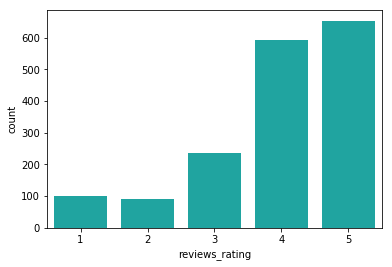

In [9]:
# Hotel ratings
g1 = sns.countplot(x = y, color = "#0abab5")

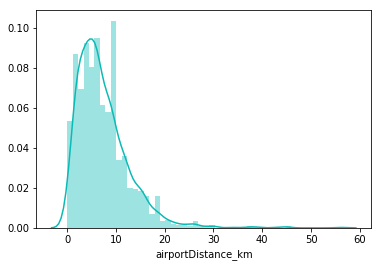

In [10]:
# Distances from nearest airport
g2 = sns.distplot(df["airportDistance_km"], color = "#0abab5")

## Random Forest

In [11]:
# Dependencies
import mord
from sklearn.ensemble import RandomForestRegressor

In [12]:
# Create a random forest regressor (for continuous explanatory variables, like scaled values)
rf = RandomForestRegressor(n_estimators = 500)
rf_reg = rf.fit(Xstd_high_var, y)

# Get the coefficient of determination (R^2) of the random forest prediction
rf_reg.score(Xstd_high_var, y)

print(f"R^2 using random forest: {rf_reg.score(Xstd_high_var, y)}")

R^2 using random forest: 0.7606791518932264


In [13]:
# Variable importance
impt = rf_reg.feature_importances_
impt_var = sorted(zip(impt, list(X.columns)), reverse = True)[0:10]
impt_var

[(0.2894942751215188, 'airportDistance_km'),
 (0.039548441721609616, 'reservations'),
 (0.037688762187307843, '2013'),
 (0.028483131017287822, 'CA'),
 (0.028430034223141026, '2011'),
 (0.0253877448706694, '2012'),
 (0.021284900246334212, 'family-friendly'),
 (0.02093786742958561, 'FL'),
 (0.020394334241520647, '2010'),
 (0.018280662490658274, 'TX')]

## Split the data into training and test sets

In [14]:
# Dependencies
from sklearn.model_selection import train_test_split

In [16]:
# Create a list of the top 10 important variables
top10 = [var[1] for var in impt_var]

# Choose variables with high importance
X2 = X[top10]

X2_standard = scaler.fit_transform(X2)

print(X2_standard.shape, y.shape)

(1670, 10) (1670,)


In [17]:
# Divide the data into training and testing data
Xstd_train, Xstd_test, y_train, y_test = train_test_split(X2_standard, y, random_state = 42, stratify = y)

print(Xstd_train.shape, Xstd_test.shape)

(1252, 10) (418, 10)


## Regression Models

In [18]:
# Create lists
ratings = list(set(y))
models = ["multinomial logistic regression", "ridge regression", "ordinal logistic regression (IT)", 
          "ordinal logistic regression (AT)", "lasso"]
predictions = []
mean_abs_error = []
mean_acc_test = []
mean_acc_train = []
R2 = []

In [19]:
# Dependencies
import mord
from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report

### Model 1: Multinomial logistic regression

In [20]:
# Create a multinomial logistic regression model
classifier1 = LogisticRegression(solver = "lbfgs", multi_class = "multinomial")

# Fit the model to the data
classifier1.fit(Xstd_train, y_train)

# Make predictions
pred = classifier1.predict(Xstd_test)
predictions.append(pred)

# Evaluate the model
score_logistic = mean_absolute_error(y_test, pred)
mean_abs_error.append(score_logistic)

# Mean accuracy scores
mean_acc_test.append(classifier1.score(Xstd_test, y_test))
mean_acc_train.append(classifier1.score(Xstd_train, y_train))

# Coefficient of determination (R^2)
r2 = r2_score(y_test, pred)
R2.append(r2)

# Confusion matrix
confusion_matrix(y_test, pred)

array([[  1,   1,   0,   4,  19],
       [  0,   0,   0,   0,  23],
       [  1,   0,   0,  16,  42],
       [  3,   0,   0,  34, 111],
       [  1,   2,   0,  26, 134]])

### Model 2: Ridge regression

In [21]:
# Create a ridge regression with three possible alphas
regression_cv = RidgeCV(alphas = [0.1, 1.0, 10.0])

# Fit the ridge regression model
model_cv = regression_cv.fit(Xstd_train, y_train)

# View the best alpha value
model_cv.alpha_

10.0

In [22]:
# Use the best alpha value in the ridge regression model
classifier2 = Ridge(alpha = 10.0)

# Fit the model to the data
classifier2.fit(Xstd_train, y_train)

# Make predictions
pred2 = classifier2.predict(Xstd_test)
predictions.append(pred2)

# Evaluate the model
score_ridge = mean_absolute_error(y_test, pred2)
mean_abs_error.append(score_ridge)

# Mean accuracy scores
mean_acc_test.append(classifier2.score(Xstd_test, y_test))
mean_acc_train.append(classifier2.score(Xstd_train, y_train))

# Coefficient of determination (R^2)
r2 = r2_score(y_test, pred2)
R2.append(r2)

### Model 3: Ordinal logistic regression

In [23]:
# Create an ordinal logistic regression model (immediate-threshold)
classifier3 = mord.LogisticIT(alpha = 1.0)

# Fit the model to the data
classifier3.fit(Xstd_train, y_train)

# Make predictions
pred3 = classifier3.predict(Xstd_test)
predictions.append(pred3)

# Evaluate the model
score_logisticIT = mean_absolute_error(y_test, pred3)
mean_abs_error.append(score_logisticIT)

# Mean accuracy scores
mean_acc_test.append(classifier3.score(Xstd_test, y_test))
mean_acc_train.append(classifier3.score(Xstd_train, y_train))

# Coefficient of determination (R^2)
r2 = r2_score(y_test, pred3)
R2.append(r2)

# Confusion matrix
confusion_matrix(y_test, pred3)

array([[  1,   0,   0,   3,  21],
       [  0,   0,   0,   1,  22],
       [  2,   0,   0,   6,  51],
       [  4,   0,   0,  13, 131],
       [  5,   0,   0,  10, 148]])

### Model 4: Ordinal logistic regression

In [24]:
# Create an ordinal logistic regression model (all-threshold)
classifier4 = mord.LogisticAT(alpha = 1.0)

# Fit the model to the data
classifier4.fit(Xstd_train, y_train)

# Make predictions
pred4 = classifier4.predict(Xstd_test)
predictions.append(pred4)

# Evaluate the model
score_logisticAT = mean_absolute_error(y_test, pred4)
mean_abs_error.append(score_logisticAT)

# Mean accuracy scores
mean_acc_test.append(classifier4.score(Xstd_test, y_test))
mean_acc_train.append(classifier4.score(Xstd_train, y_train))

# Coefficient of determination (R^2)
r2 = r2_score(y_test, pred4)
R2.append(r2)

# Confusion matrix
confusion_matrix(y_test, pred4)

array([[  0,   0,   4,  21,   0],
       [  0,   0,   0,  23,   0],
       [  0,   0,   2,  57,   0],
       [  0,   0,   5, 143,   0],
       [  0,   1,   5, 156,   1]])

### Model 5: Lasso Regression

In [25]:
# Use the best alpha value in the lasso regression model
classifier5 = Lasso(alpha = 1.0)

# Fit the model to the data
classifier5.fit(Xstd_train, y_train)

# Make predictions
pred5 = classifier2.predict(Xstd_test)
predictions.append(pred5)

# Evaluate the model
score_lasso = mean_absolute_error(y_test, pred5)
mean_abs_error.append(score_lasso)

# Mean accuracy scores
mean_acc_test.append(classifier5.score(Xstd_test, y_test))
mean_acc_train.append(classifier5.score(Xstd_train, y_train))

# Coefficient of determination (R^2)
r2 = r2_score(y_test, pred5)
R2.append(r2)

### Model comparisons

In [26]:
# Model accuracy
df_acc = pd.DataFrame({"Model": models, "MAE": mean_abs_error, "Train Mean Accuracy": mean_acc_train, 
                       "Test Mean Accuracy": mean_acc_test, "R^2": R2})

df_acc.head()

,Model,MAE,Train Mean Accuracy,Test Mean Accuracy,R^2
0,multinomial logistic regression,0.995215,0.405751,0.404306,-0.735064
1,ridge regression,0.855946,0.055728,-0.014504,-0.014504
2,ordinal logistic regression (IT),1.066986,0.396166,0.387560,-0.931977
3,ordinal logistic regression (AT),0.832536,-0.807508,-0.832536,-0.010573
4,lasso,0.855946,0.000000,-0.000017,-0.014504


In [27]:
# Model predictions
df_pred = pd.DataFrame({"Actual": y_test, "MLR": pred, "RidgeReg": pred2, "OLR_AT": pred3, 
                        "OLR_IT": pred4, "Lasso": pred5})

df_pred.head()

,Actual,MLR,RidgeReg,OLR_AT,OLR_IT,Lasso
Name,,,,,,
Best Western Orange Plaza,4,4,3.811044,4,4,3.811044
"The Roosevelt New Orleans, A Waldorf Astoria Hotel",4,5,4.055654,5,4,4.055654
America's Best Value Inn,1,5,4.011240,5,4,4.011240
Stonebrook Lodge,4,5,4.081033,5,4,4.081033
Hampton Inn Suites West Des Moines/SW Mall Area,5,5,4.061999,5,4,4.061999


In [28]:
# Create a function that generates classification reports
def class_report(model, prediction):
    print(f"Model: {model}")
    print(classification_report(y_test, prediction))
    print("-----")

In [29]:
# Choose only the models with categorical predictions
# MLR, OLR_AT, OLR_IT
idx = [0] + [2,3] 

# Loop through the idx to print their classification reports
for i in idx:
    class_report(models[i], predictions[i])

Model: multinomial logistic regression
             precision    recall  f1-score   support

          1       0.17      0.04      0.06        25
          2       0.00      0.00      0.00        23
          3       0.00      0.00      0.00        59
          4       0.42      0.23      0.30       148
          5       0.41      0.82      0.54       163

avg / total       0.32      0.40      0.32       418

-----
Model: ordinal logistic regression (IT)
             precision    recall  f1-score   support

          1       0.08      0.04      0.05        25
          2       0.00      0.00      0.00        23
          3       0.00      0.00      0.00        59
          4       0.39      0.09      0.14       148
          5       0.40      0.91      0.55       163

avg / total       0.30      0.39      0.27       418

-----
Model: ordinal logistic regression (AT)
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        25
          2   

/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Principal Component Analysis

In [30]:
# Dependencies
import numpy as np
from sklearn.decomposition import PCA

In [31]:
# Calculate covariance
mean_vec = np.mean(X2_standard, axis = 0)
covar_matrix = (X2_standard - mean_vec).T.dot((X2_standard - mean_vec)/ (X2_standard.shape[0]-1))
print(f"Covariance matrix\n{covar_matrix}")

Covariance matrix
[[ 1.00059916e+00  3.15373387e-02 -2.54227412e-02  7.45586850e-02
  -2.04152860e-02  5.65212609e-02 -1.89765513e-02  3.10799937e-02
   4.57382201e-03 -2.21671321e-02]
 [ 3.15373387e-02  1.00059916e+00 -8.01586021e-04  1.23472821e-01
  -2.35502191e-02  2.59629437e-02  1.68688108e-01 -2.41517170e-03
   1.81821079e-02  3.61812274e-02]
 [-2.54227412e-02 -8.01586021e-04  1.00059916e+00 -1.19747712e-02
  -1.08026792e-02 -1.62033223e-02  5.93379869e-03  1.91586097e-02
   9.11626459e-03 -2.65088342e-03]
 [ 7.45586850e-02  1.23472821e-01 -1.19747712e-02  1.00059916e+00
  -2.59200125e-02  3.90825863e-02  3.15224854e-02 -9.12810764e-02
   7.20685972e-03 -8.18731811e-02]
 [-2.04152860e-02 -2.35502191e-02 -1.08026792e-02 -2.59200125e-02
   1.00059916e+00 -9.32708693e-03 -2.79258440e-02 -5.72408271e-03
   2.72962534e-02  1.59542487e-02]
 [ 5.65212609e-02  2.59629437e-02 -1.62033223e-02  3.90825863e-02
  -9.32708693e-03  1.00059916e+00 -5.19604892e-03 -1.03609451e-02
   1.40842145e-

In [32]:
# Eigen decomposition of the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(covar_matrix)

print(f"Eigenvalues:\n{eig_vals}\n\nEigenvectors: {eig_vecs}")

Eigenvalues:
[1.25612689 0.78378008 0.81427528 1.13150074 1.09875142 0.92816211
 0.95496684 1.0309428  0.99606437 1.01142109]

Eigenvectors: [[ 0.23892721  0.13644033  0.23021401 -0.44843918  0.11700838  0.68442905
  -0.02556037  0.42955036 -0.02734798 -0.04639819]
 [ 0.62111968  0.51645594 -0.50685823  0.23104468  0.02334801 -0.0070223
  -0.01273599  0.00248969  0.14108335 -0.12856649]
 [-0.052469    0.02053456  0.02859676  0.17346948  0.15694245  0.19428338
   0.42834144 -0.23835668 -0.54797138 -0.6024749 ]
 [ 0.50849217 -0.62804678 -0.16460205 -0.39347208 -0.0782412  -0.00652792
   0.10638266 -0.36941288  0.08397386 -0.06387319]
 [-0.17687166  0.0011291   0.03771951  0.04662364 -0.28660854  0.08674033
   0.56662308  0.11343339  0.68141858 -0.27783113]
 [ 0.20214112  0.03451564  0.05936538 -0.2499522  -0.18774703 -0.56194161
   0.37874343  0.536334   -0.32890145  0.04053463]
 [ 0.45786256 -0.15187743  0.67331081  0.50055899  0.19151892 -0.08139434
   0.01477885  0.04508828  0.1304109

In [33]:
# Confirm that each eigenvector has the same unit length of 1.0
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print("Ok!")    

Ok!


In [34]:
# Create eigenvalue, eigenvector tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

# Sort the eig_pairs from high to low
eig_pairs.sort()
eig_pairs.reverse()

print("Eigenvalues in descending order:")

for p in eig_pairs:
    print(p[0])

Eigenvalues in descending order:
1.2561268857943175
1.1315007431729824
1.0987514152152738
1.0309427964032174
1.011421093247731
0.9960643658761473
0.9549668400595661
0.9281621136459388
0.8142752795523133
0.783780078776088


In [35]:
# How many PCs to use? Use cumulative explained variance
tot = sum(eig_vals)
var_exp = [(i/tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

x_axes = [f"PC {i}" for i in range(1, 11)]

# Create a dataframe for PCA data
df_PCA = pd.DataFrame({"PC":x_axes, "explained variance": var_exp, 
                       "cumulative explained variance": list(cum_var_exp)})
df_PCA

,PC,explained variance,cumulative explained variance
0,PC 1,12.553747,12.553747
1,PC 2,11.308232,23.861979
2,PC 3,10.980935,34.842914
3,PC 4,10.303255,45.146169
4,PC 5,10.108155,55.254323
5,PC 6,9.954679,65.209002
6,PC 7,9.543950,74.752952
7,PC 8,9.276063,84.029016
8,PC 9,8.137877,92.166893
9,PC 10,7.833107,100.000000


Text(0.5,0,'Principal component')

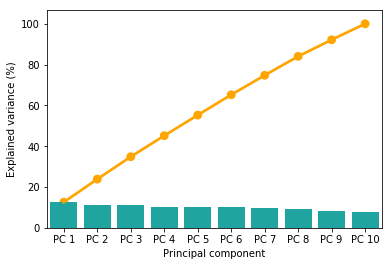

In [36]:
# Plot the graph of PC and cumulative explained variance
fig, ax = plt.subplots()
sns.pointplot(x = df_PCA["PC"], y = df_PCA["cumulative explained variance"], color = "orange", 
              ax = ax, label = "Cumulative Explained Variance (%)")
sns.barplot(x = df_PCA["PC"], y = df_PCA["explained variance"], color = "#0abab5", 
            ax = ax, label = "Explained Variance (%)")
ax.set_ylabel("Explained variance (%)")
ax.set_xlabel("Principal component")

In [37]:
# Reduce the 10-dimensional feature space to a 2-dimensional feature subspace
# Use top 2 eigenvectors

matrix = np.hstack((eig_pairs[0][1].reshape(10, 1), 
                    eig_pairs[1][1].reshape(10, 1)))

print(f"Matrix W\n{matrix}")

Matrix W
[[ 0.23892721 -0.44843918]
 [ 0.62111968  0.23104468]
 [-0.052469    0.17346948]
 [ 0.50849217 -0.39347208]
 [-0.17687166  0.04662364]
 [ 0.20214112 -0.2499522 ]
 [ 0.45786256  0.50055899]
 [-0.11304373  0.10437563]
 [ 0.01647089 -0.05037352]
 [ 0.03120791  0.48163035]]


In [38]:
# 2-D feature subspace
Y = X2_standard.dot(matrix)

# Create a dataframe for the feature subspace
x_eig = [pair[0] for pair in Y]
y_eig = [pair[1] for pair in Y]   

df_PCA2 = pd.DataFrame({"rating": y, "x_eig": x_eig, "y_eig": y_eig})
df_PCA2.head()

,rating,x_eig,y_eig
Name,,,
1906 Lodge At Coronado Beach,5,2.668788,-0.720044
250 Main Hotel,5,0.951608,0.608712
AC Hotel Chicago Downtown,4,-0.249953,-0.918930
AC Hotel Miami Beach,5,-0.646688,-0.594274
AC Hotel by Marriott Boston Downtown,5,-0.730500,-0.016999


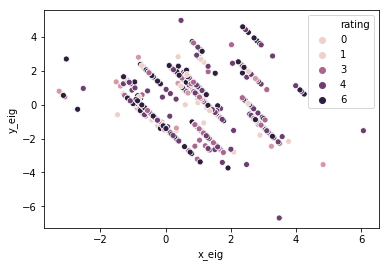

In [39]:
# PCA projection on 2-dimensions
sns.scatterplot(x = df_PCA2["x_eig"], y = df_PCA2["y_eig"], hue = df_PCA2["rating"])

## Using only hotel features; no years

### Slice df to get hotel features only

In [40]:
# Define the response (y) and the explanatory (X) variables (removing the years)
columns = ["reviews_rating"] + list(df.columns[108:127])

Xfeat = df.drop(columns = columns, axis = 1)
y = df["reviews_rating"]

# Standardise the explanatory variables
scaler = StandardScaler()
Xfeat_standard = scaler.fit_transform(Xfeat)

# Convert review rating into whole number
y = y.astype(int)

print(Xfeat_standard.shape, y.shape)

(1670, 107) (1670,)


### Remove zero-variance variables

In [41]:
# Conduct variance thresholding
Xfeat_std_high_var = thresholder.fit_transform(Xfeat_standard)

print(f"Number of variables before thresholding: {Xfeat.shape[1]}")
print(f"Number of variables after thresholding: {Xfeat_std_high_var.shape[1]}")

Number of variables before thresholding: 107
Number of variables after thresholding: 107


### Use random forest to get the top 10 important variables

In [42]:
# Use the random forest regressor (for continuous explanatory variables, like scaled values)
feat_rf_reg = rf.fit(Xfeat_std_high_var, y)

# Get the coefficient of determination (R^2) of the random forest prediction
feat_rf_reg.score(Xfeat_std_high_var, y)

print(f"R^2 using random forest: {feat_rf_reg.score(Xfeat_std_high_var, y)}")

R^2 using random forest: 0.5277491655668434


In [45]:
# Variable importance
feat_impt = feat_rf_reg.feature_importances_
feat_impt_var = sorted(zip(feat_impt, list(Xfeat.columns)), reverse = True)[0:10]
feat_impt_var

[(0.3415513607410754, 'airportDistance_km'),
 (0.051589462132300305, 'reservations'),
 (0.03713660964849733, 'family-friendly'),
 (0.023007000653896013, 'breakfast'),
 (0.019821306123764454, 'FL'),
 (0.015981063424590672, 'TX'),
 (0.015139915363124434, 'CA'),
 (0.014587872218973945, 'meeting'),
 (0.014521824367281931, 'OH'),
 (0.01394804156491495, 'GA')]

### Split the data into training and test sets

In [52]:
# Create a list of the top 10 important variables
feat_top10 = [var[1] for var in feat_impt_var]

# Choose variables with high importance
Xfeat2 = Xfeat[feat_top10]

Xfeat2_standard = scaler.fit_transform(Xfeat2)

print(Xfeat2_standard.shape, y.shape)

(1670, 10) (1670,)


In [54]:
# Divide the data into training and testing data
Xstd1_train, Xstd1_test, y_train, y_test = train_test_split(Xfeat2_standard, y, random_state = 42, stratify = y)

print(Xstd1_train.shape, Xstd1_test.shape)

(1252, 10) (418, 10)


### Regression Models

In [56]:
# Create lists
ratings1 = list(set(y))
models1 = ["multinomial logistic regression", "ridge regression", "ordinal logistic regression (IT)", 
          "ordinal logistic regression (AT)", "lasso"]
predictions1 = []
mean_abs_error1 = []
mean_acc_test1 = []
mean_acc_train1 = []
R2_1 = []

#### Model 1: Multinomial logistic regression

In [57]:
# Fit the model to the data
classifier1.fit(Xstd1_train, y_train)

# Make predictions
pred = classifier1.predict(Xstd1_test)
predictions1.append(pred)

# Evaluate the model
score_logistic = mean_absolute_error(y_test, pred)
mean_abs_error1.append(score_logistic)

# Mean accuracy scores
mean_acc_test1.append(classifier1.score(Xstd1_test, y_test))
mean_acc_train1.append(classifier1.score(Xstd1_train, y_train))

# Coefficient of determination (R^2)
r2 = r2_score(y_test, pred)
R2_1.append(r2)

# Confusion matrix
confusion_matrix(y_test, pred)

array([[  0,   0,   0,   5,  20],
       [  0,   0,   0,   2,  21],
       [  0,   0,   0,  19,  40],
       [  0,   0,   0,  41, 107],
       [  0,   0,   0,  29, 134]])

#### Model 2: Ridge regression

In [58]:
# Fit the model to the data
classifier2.fit(Xstd1_train, y_train)

# Make predictions
pred2 = classifier2.predict(Xstd1_test)
predictions1.append(pred2)

# Evaluate the model
score_ridge = mean_absolute_error(y_test, pred2)
mean_abs_error1.append(score_ridge)

# Mean accuracy scores
mean_acc_test1.append(classifier2.score(Xstd_test, y_test))
mean_acc_train1.append(classifier2.score(Xstd_train, y_train))

# Coefficient of determination (R^2)
r2 = r2_score(y_test, pred2)
R2_1.append(r2)

#### Model 3: Ordinal logistic regression

In [59]:
# Fit the model to the data
classifier3.fit(Xstd1_train, y_train)

# Make predictions
pred3 = classifier3.predict(Xstd1_test)
predictions1.append(pred3)

# Evaluate the model
score_logisticIT = mean_absolute_error(y_test, pred3)
mean_abs_error1.append(score_logisticIT)

# Mean accuracy scores
mean_acc_test1.append(classifier3.score(Xstd1_test, y_test))
mean_acc_train1.append(classifier3.score(Xstd1_train, y_train))

# Coefficient of determination (R^2)
r2 = r2_score(y_test, pred3)
R2_1.append(r2)

# Confusion matrix
confusion_matrix(y_test, pred3)

array([[  0,   0,   0,   3,  22],
       [  0,   0,   0,   1,  22],
       [  0,   0,   0,  15,  44],
       [  0,   0,   0,  24, 124],
       [  0,   0,   0,  17, 146]])

#### Model 4: Ordinal logistic regression

In [60]:
# Fit the model to the data
classifier4.fit(Xstd1_train, y_train)

# Make predictions
pred4 = classifier4.predict(Xstd1_test)
predictions1.append(pred4)

# Evaluate the model
score_logisticAT = mean_absolute_error(y_test, pred4)
mean_abs_error1.append(score_logisticAT)

# Mean accuracy scores
mean_acc_test1.append(classifier4.score(Xstd1_test, y_test))
mean_acc_train1.append(classifier4.score(Xstd1_train, y_train))

# Coefficient of determination (R^2)
r2 = r2_score(y_test, pred4)
R2_1.append(r2)

# Confusion matrix
confusion_matrix(y_test, pred4)

array([[  0,   0,   0,  25,   0],
       [  0,   0,   0,  23,   0],
       [  0,   0,   0,  58,   1],
       [  0,   0,   0, 136,  12],
       [  0,   0,   0, 157,   6]])

#### Model 5: Lasso Regression

In [61]:
# Fit the model to the data
classifier5.fit(Xstd1_train, y_train)

# Make predictions
pred5 = classifier2.predict(Xstd1_test)
predictions1.append(pred5)

# Evaluate the model
score_lasso = mean_absolute_error(y_test, pred5)
mean_abs_error1.append(score_lasso)

# Mean accuracy scores
mean_acc_test1.append(classifier5.score(Xstd_test, y_test))
mean_acc_train1.append(classifier5.score(Xstd_train, y_train))

# Coefficient of determination (R^2)
r2 = r2_score(y_test, pred5)
R2_1.append(r2)

#### Model comparisons

In [62]:
# Model accuracy
df_acc1 = pd.DataFrame({"Model": models, "MAE": mean_abs_error1, "Train Mean Accuracy": mean_acc_train1, 
                       "Test Mean Accuracy": mean_acc_test1, "R^2": R2_1})

df_acc1

,Model,MAE,Train Mean Accuracy,Test Mean Accuracy,R^2
0,multinomial logistic regression,0.949761,0.419329,0.418660,-0.629177
1,ridge regression,0.847563,-0.009152,-0.005988,0.006674
2,ordinal logistic regression (IT),0.978469,0.400160,0.406699,-0.696053
3,ordinal logistic regression (AT),0.837321,-0.821086,-0.837321,-0.018003
4,lasso,0.847563,0.000000,-0.000017,0.006674


In [65]:
df_acc

,Model,MAE,Train Mean Accuracy,Test Mean Accuracy,R^2
0,multinomial logistic regression,0.995215,0.405751,0.404306,-0.735064
1,ridge regression,0.855946,0.055728,-0.014504,-0.014504
2,ordinal logistic regression (IT),1.066986,0.396166,0.387560,-0.931977
3,ordinal logistic regression (AT),0.832536,-0.807508,-0.832536,-0.010573
4,lasso,0.855946,0.000000,-0.000017,-0.014504


In [63]:
# Model predictions
df_pred1 = pd.DataFrame({"Actual": y_test, "MLR": pred, "RidgeReg": pred2, "OLR_AT": pred3, 
                        "OLR_IT": pred4, "Lasso": pred5})

df_pred.head()

,Actual,MLR,RidgeReg,OLR_AT,OLR_IT,Lasso
Name,,,,,,
Best Western Orange Plaza,4,4,3.811044,4,4,3.811044
"The Roosevelt New Orleans, A Waldorf Astoria Hotel",4,5,4.055654,5,4,4.055654
America's Best Value Inn,1,5,4.011240,5,4,4.011240
Stonebrook Lodge,4,5,4.081033,5,4,4.081033
Hampton Inn Suites West Des Moines/SW Mall Area,5,5,4.061999,5,4,4.061999


In [66]:
# Choose only the models with categorical predictions
# MLR, OLR_AT, OLR_IT
idx = [0] + [2,3] 

# Loop through the idx to print their classification reports
for i in idx:
    class_report(models1[i], predictions1[i])

Model: multinomial logistic regression
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        25
          2       0.00      0.00      0.00        23
          3       0.00      0.00      0.00        59
          4       0.43      0.28      0.34       148
          5       0.42      0.82      0.55       163

avg / total       0.31      0.42      0.33       418

-----
Model: ordinal logistic regression (IT)
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        25
          2       0.00      0.00      0.00        23
          3       0.00      0.00      0.00        59
          4       0.40      0.16      0.23       148
          5       0.41      0.90      0.56       163

avg / total       0.30      0.41      0.30       418

-----
Model: ordinal logistic regression (AT)
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        25
          2   

/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
